In [1]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings  # Import warnings module to suppress warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)  # Suppress deprecation warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress PCA parallelism warning

In [3]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge datasets on CustomerID
data = pd.merge(customers, transactions, on='CustomerID')

In [4]:
# Aggregate transaction data for each customer
customer_agg = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum',
    'TransactionID': 'nunique'
}).reset_index()

# Merge aggregated data with customer profile
customer_data = pd.merge(customers, customer_agg, on='CustomerID')

In [5]:
# Encode categorical variables (Region)
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

# Normalize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_data.drop(columns=['CustomerID', 'CustomerName', 'SignupDate']))

In [6]:
# Apply PCA for dimensionality reduction
pca = PCA(n_components=2, random_state=42)
pca_data = pca.fit_transform(scaled_data)

In [7]:
# Determine the optimal number of clusters using the Davies-Bouldin Index
best_db_index = float('inf')
best_clusters = None
best_n_clusters = 2

for n_clusters in range(2, 11):
    kmeans = KMeans(
        n_clusters=n_clusters,
        random_state=42
    )
    clusters = kmeans.fit_predict(pca_data)
    db_index = davies_bouldin_score(pca_data, clusters)

    if db_index < best_db_index:
        best_db_index = db_index
        best_clusters = clusters
        best_n_clusters = n_clusters

print(f"Davies-Bouldin Index: {best_db_index}")
print(f"Optimal Number of Clusters: {best_n_clusters}")

Davies-Bouldin Index: 0.605025526784406
Optimal Number of Clusters: 10


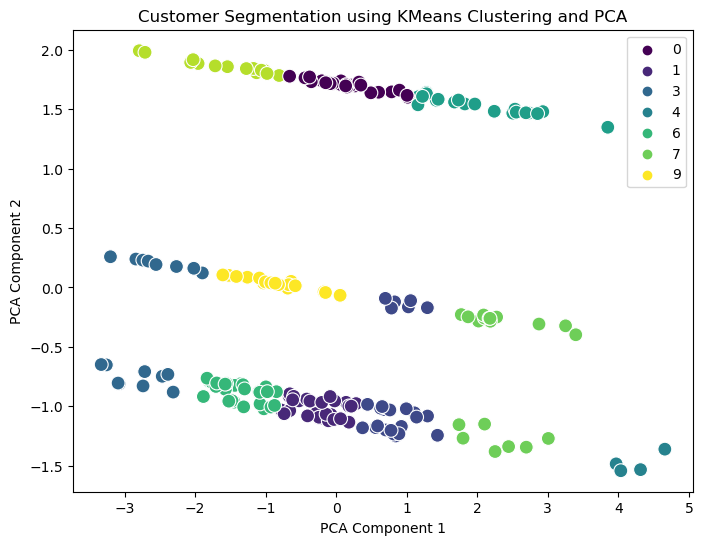

In [8]:
# Add cluster labels to the data
customer_data['Cluster'] = best_clusters

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=best_clusters, palette='viridis', s=100)
plt.title('Customer Segmentation using KMeans Clustering and PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [9]:
# Analyze cluster characteristics
numerical_columns = customer_data.select_dtypes(include=[np.number]).columns
cluster_summary = customer_data.groupby('Cluster')[numerical_columns].mean()

print(cluster_summary)

          TotalValue   Quantity  TransactionID  Cluster
Cluster                                                
0        3552.177917  12.416667       5.041667      0.0
1        3214.763333  12.033333       5.000000      1.0
2        4370.940769  15.884615       6.346154      2.0
3         852.470588   3.117647       1.588235      3.0
4        7864.817500  28.500000      10.500000      4.0
5        5641.052500  19.800000       7.100000      5.0
6        2220.469231   8.461538       3.346154      6.0
7        5784.272632  21.473684       8.157895      7.0
8        1418.616000   6.333333       2.733333      8.0
9        2609.499444   9.944444       3.888889      9.0
